## **Taller 2** ##

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior.

Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.


In [3]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [10]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [13]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4729.
Date:               lun, 03 nov. 2025   Prob (F-statistic):          1.02e-150
Time:                        09:37:25   Log-Likelihood:                -1559.9
No. Observations:                 222   AIC:                             3124.
Df Residuals:                     220   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6962.4958     36.871    188.835      0.0

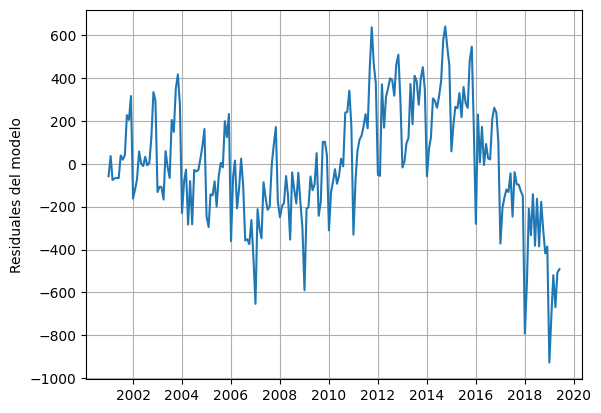

In [14]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

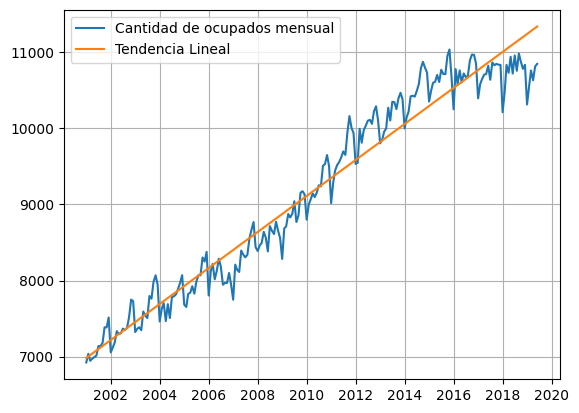

In [15]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [16]:
h=12
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [17]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

    Point_forecast      lower_95      upper_95
0     11359.208189  10814.820716  11903.595662
1     11378.924388  10834.471236  11923.377539
2     11398.640587  10854.121178  11943.159995
3     11418.356786  10873.770542  11962.943029
4     11438.072984  10893.419328  11982.726641
5     11457.789183  10913.067536  12002.510831
6     11477.505382  10932.715166  12022.295598
7     11497.221581  10952.362220  12042.080943
8     11516.937780  10972.008696  12061.866864
9     11536.653979  10991.654595  12081.653363
10    11556.370178  11011.299918  12101.440438
11    11576.086377  11030.944664  12121.228090


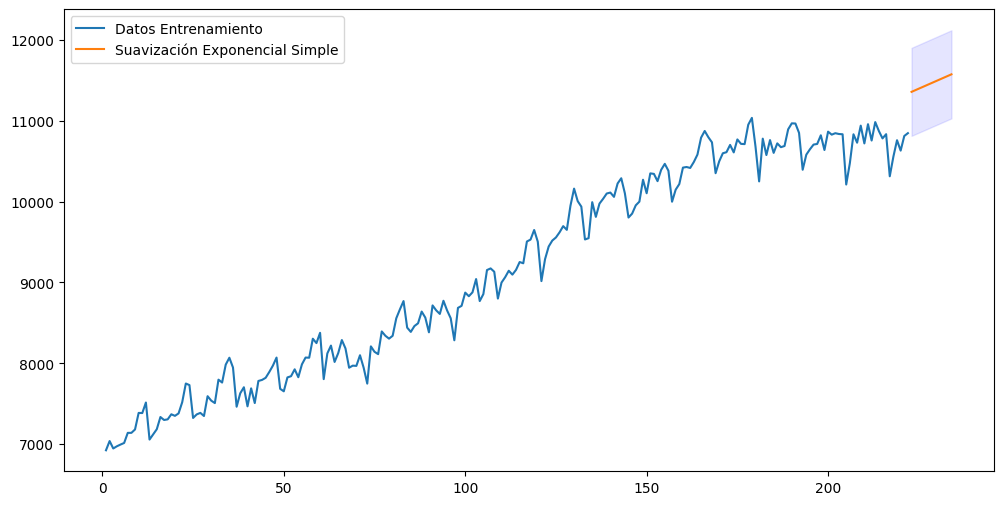

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [ ]:
### **7. Tendencia Cuadratica**

In [19]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     2560.
Date:               lun, 03 nov. 2025   Prob (F-statistic):          1.33e-152
Time:                        09:39:12   Log-Likelihood:                -1551.0
No. Observations:                 222   AIC:                             3108.
Df Residuals:                     219   BIC:                             3118.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6790.8804     53.552    126.810      0.0

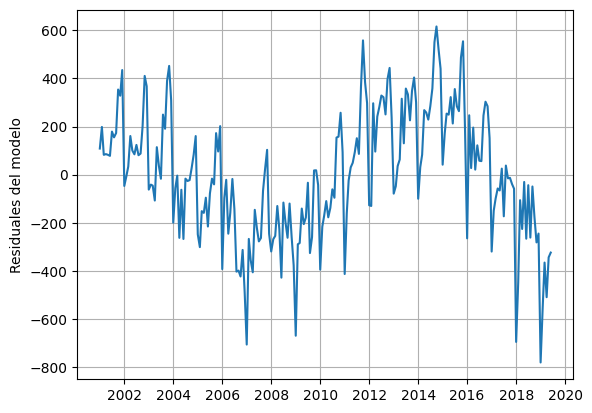

In [20]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

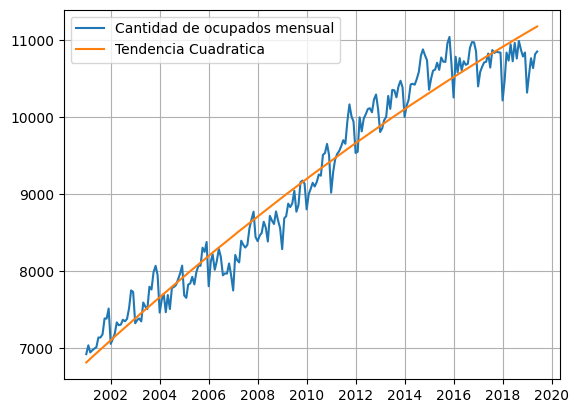

In [22]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [23]:
h=12
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [24]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

    Point_forecast      lower_95      upper_95
0     11187.592748  10657.511767  11717.673730
1     11202.691491  10672.226911  11733.156072
2     11217.749007  10686.889054  11748.608961
3     11232.765296  10701.497992  11764.032599
4     11247.740357  10716.053522  11779.427192
5     11262.674191  10730.555438  11794.792944
6     11277.566798  10745.003535  11810.130060
7     11292.418177  10759.397608  11825.438746
8     11307.228329  10773.737450  11840.719209
9     11321.997254  10788.022854  11855.971654
10    11336.724952  10802.253614  11871.196289
11    11351.411422  10816.429523  11886.393322


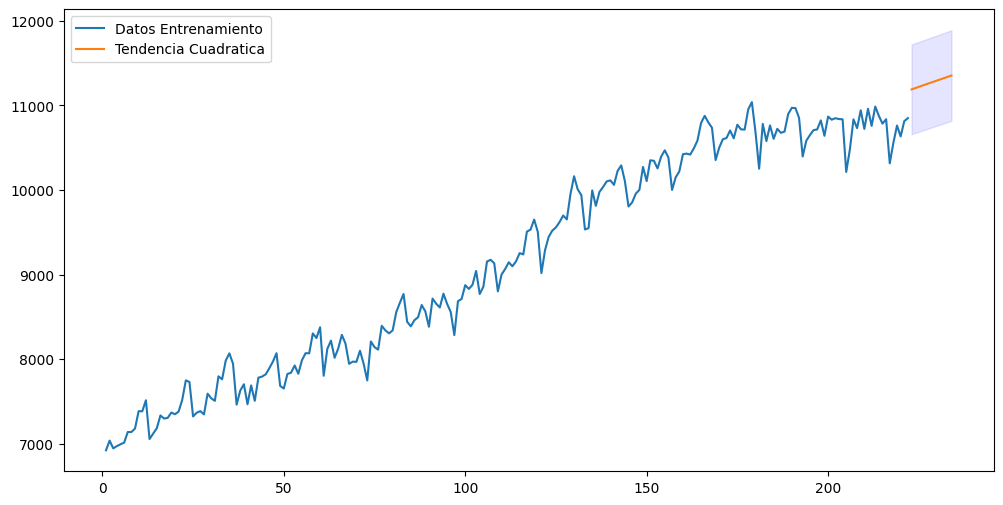

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Cuadratica")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [26]:
data.index.month.value_counts()

mes
1     19
2     19
3     19
4     19
5     19
6     19
7     18
8     18
9     18
10    18
11    18
12    18
Name: count, dtype: int64

In [27]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.2687
Date:               lun, 03 nov. 2025   Prob (F-statistic):              0.991
Time:                        09:40:37   Log-Likelihood:                -1903.9
No. Observations:                 222   AIC:                             3832.
Df Residuals:                     210   BIC:                             3873.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8808.2176    302.768     29.092      0.0

In [28]:
month_dummies


,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,
2001-01-01,0,0,0,0,0,0,0,0,0,0,0
2001-02-01,1,0,0,0,0,0,0,0,0,0,0
2001-03-01,0,1,0,0,0,0,0,0,0,0,0
2001-04-01,0,0,1,0,0,0,0,0,0,0,0
2001-05-01,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2019-02-01,1,0,0,0,0,0,0,0,0,0,0
2019-03-01,0,1,0,0,0,0,0,0,0,0,0
2019-04-01,0,0,1,0,0,0,0,0,0,0,0


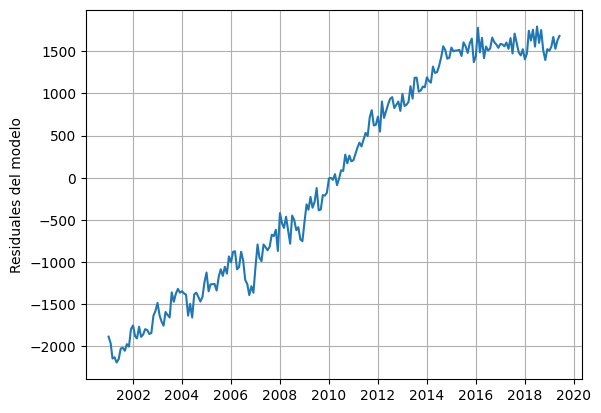

In [29]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

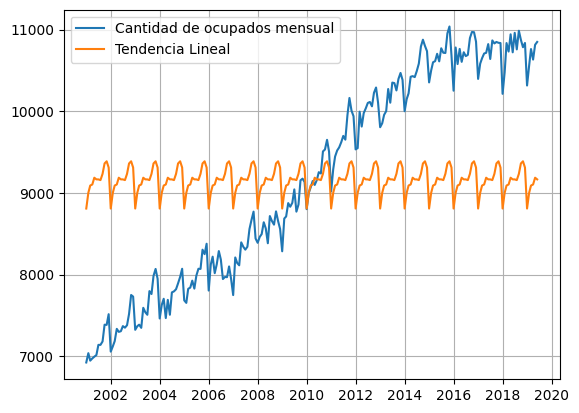

In [30]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [31]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=12,freq='MS')

x_for = pd.get_dummies(range_dates.month,drop_first=True).astype(int)
X_for= sm.add_constant(x_for)

In [32]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast     lower_95      upper_95
2019-07-01     9164.935167  6492.018221  11837.852112
2019-08-01     9156.633500  6483.716554  11829.550446
2019-09-01     9232.988500  6560.071554  11905.905446
2019-10-01     9359.934944  6687.017999  12032.851890
2019-11-01     9386.702222  6713.785277  12059.619168
2019-12-01     9310.332667  6637.415721  11983.249612
2020-01-01     8808.217632  6139.005354  11477.429909
2020-02-01     9001.037684  6331.825407  11670.249961
2020-03-01     9090.037158  6420.824881  11759.249435
2020-04-01     9102.647316  6433.435039  11771.859593
2020-05-01     9185.505368  6516.293091  11854.717646
2020-06-01     9165.273789  6496.061512  11834.486067


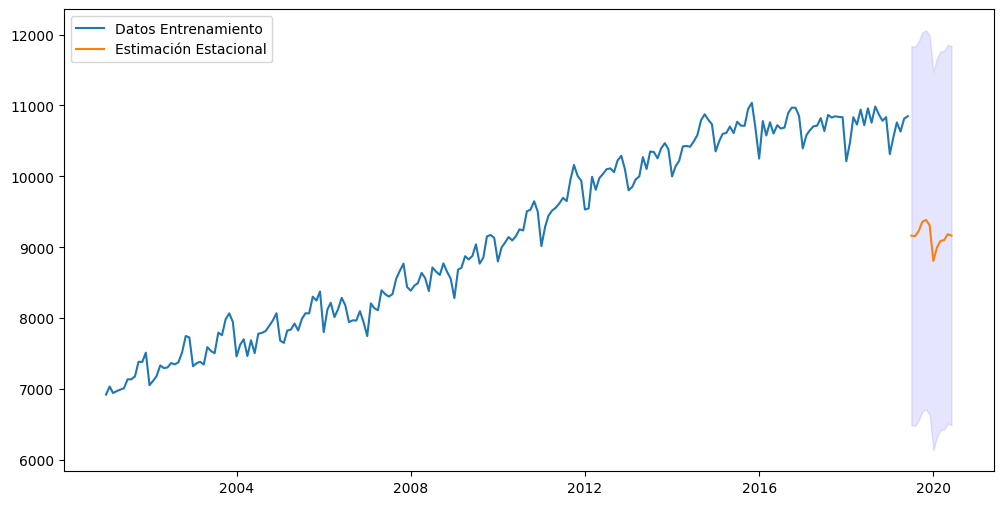

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [34]:
### **9. Tendencia + Estacionalidad**

In [37]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True).set_index(data.index).astype(int)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     502.6
Date:               lun, 03 nov. 2025   Prob (F-statistic):          3.33e-149
Time:                        09:42:35   Log-Likelihood:                -1519.4
No. Observations:                 222   AIC:                             3067.
Df Residuals:                     208   BIC:                             3114.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6508.3401     69.460     93.700      0.0

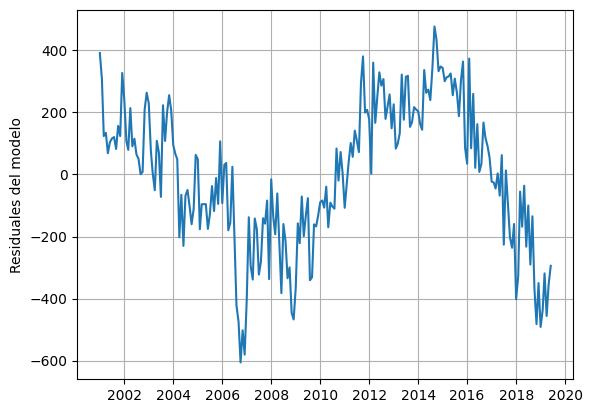

In [38]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

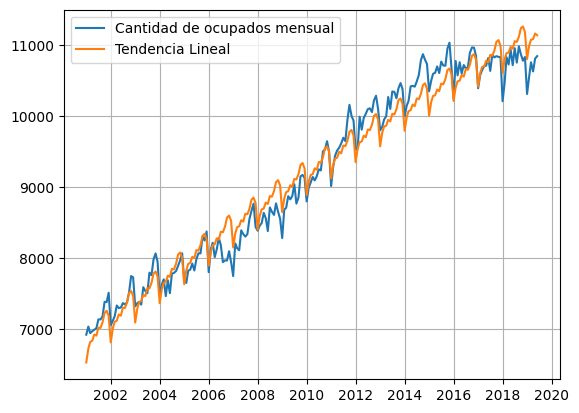

In [39]:
plt.plot(y,label="Cantidad de ocupados mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [41]:
h=12
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
0,1.0,223.0,49729.0,False,False,False,False,False,True,False,False,False,False,False
1,1.0,224.0,50176.0,False,False,False,False,False,False,True,False,False,False,False
2,1.0,225.0,50625.0,False,False,False,False,False,False,False,True,False,False,False
3,1.0,226.0,51076.0,False,False,False,False,False,False,False,False,True,False,False
4,1.0,227.0,51529.0,False,False,False,False,False,False,False,False,False,True,False
5,1.0,228.0,51984.0,False,False,False,False,False,False,False,False,False,False,True
6,1.0,229.0,52441.0,False,False,False,False,False,False,False,False,False,False,False
7,1.0,230.0,52900.0,True,False,False,False,False,False,False,False,False,False,False
8,1.0,231.0,53361.0,False,True,False,False,False,False,False,False,False,False,False
9,1.0,232.0,53824.0,False,False,True,False,False,False,False,False,False,False,False


In [43]:
dt = season_pol_2.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

            Point_forecast      lower_95      upper_95
2019-07-01    11247.611440  10763.869333  11731.353547
2019-08-01    11234.988869  10750.954256  11719.023481
2019-09-01    11307.022964  10822.688332  11791.357595
2019-10-01    11429.648504  10945.006353  11914.290654
2019-11-01    11452.094877  10967.137722  11937.052032
2019-12-01    11371.404416  10886.124786  11856.684047
2020-01-01    10991.411804  10506.734445  11476.089163
2020-02-01    11179.683536  10694.665689  11664.701383
2020-03-01    11264.134689  10778.768088  11749.501289
2020-04-01    11272.196526  10786.472926  11757.920126
2020-05-01    11350.506258  10864.417430  11836.595086
2020-06-01    11325.726358  10839.264092  11812.188624


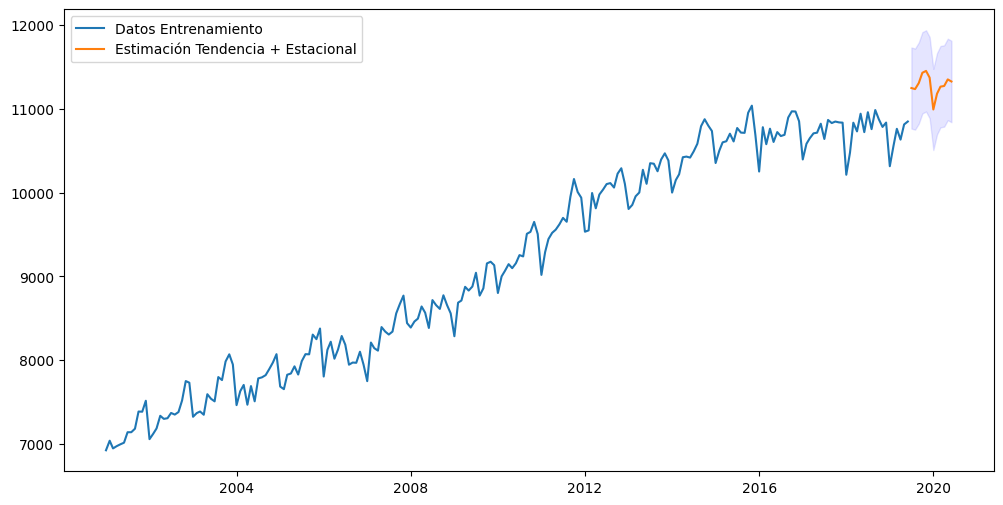

In [44]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **10. Comparación de modelos**

Para realizar la comparación de los modelos se debe usar una metrica de desempeño, en la clase anterior usamos el RMSE, la comparación se debe hacer fuera de muestra.